In [1]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 1000
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
%matplotlib inline

In [2]:
surrounding_pdf = pd.read_csv('../UseCase_3_Datasets/store_surrounding_pdf_exp.csv')
store_sales = pd.read_csv('../UseCase_3_Datasets/sales_filtered_trend_daily.csv')
sales_pdf_daily_sub = store_sales[['store_code','trend']]

In [3]:
print("Surrounding Shape",surrounding_pdf.shape)
print("Sales Shape",sales_pdf_daily_sub.shape)

Surrounding Shape (540, 181)
Sales Shape (906, 2)


In [4]:
#Join Store and Surroounding datasets
sales_surrounding_pdf = pd.merge(sales_pdf_daily_sub,surrounding_pdf,on='store_code',how='inner')
sales_surrounding_pdf = sales_surrounding_pdf.drop_duplicates()
# Dropping columns that do not provide useful information for this analysis
for i in sales_surrounding_pdf.columns:
    if sales_surrounding_pdf[i].nunique() == 1:
        sales_surrounding_pdf.drop(i, axis = 1, inplace = True)
print("Sales Surrounding Shape",sales_surrounding_pdf.shape)

Sales Surrounding Shape (540, 177)


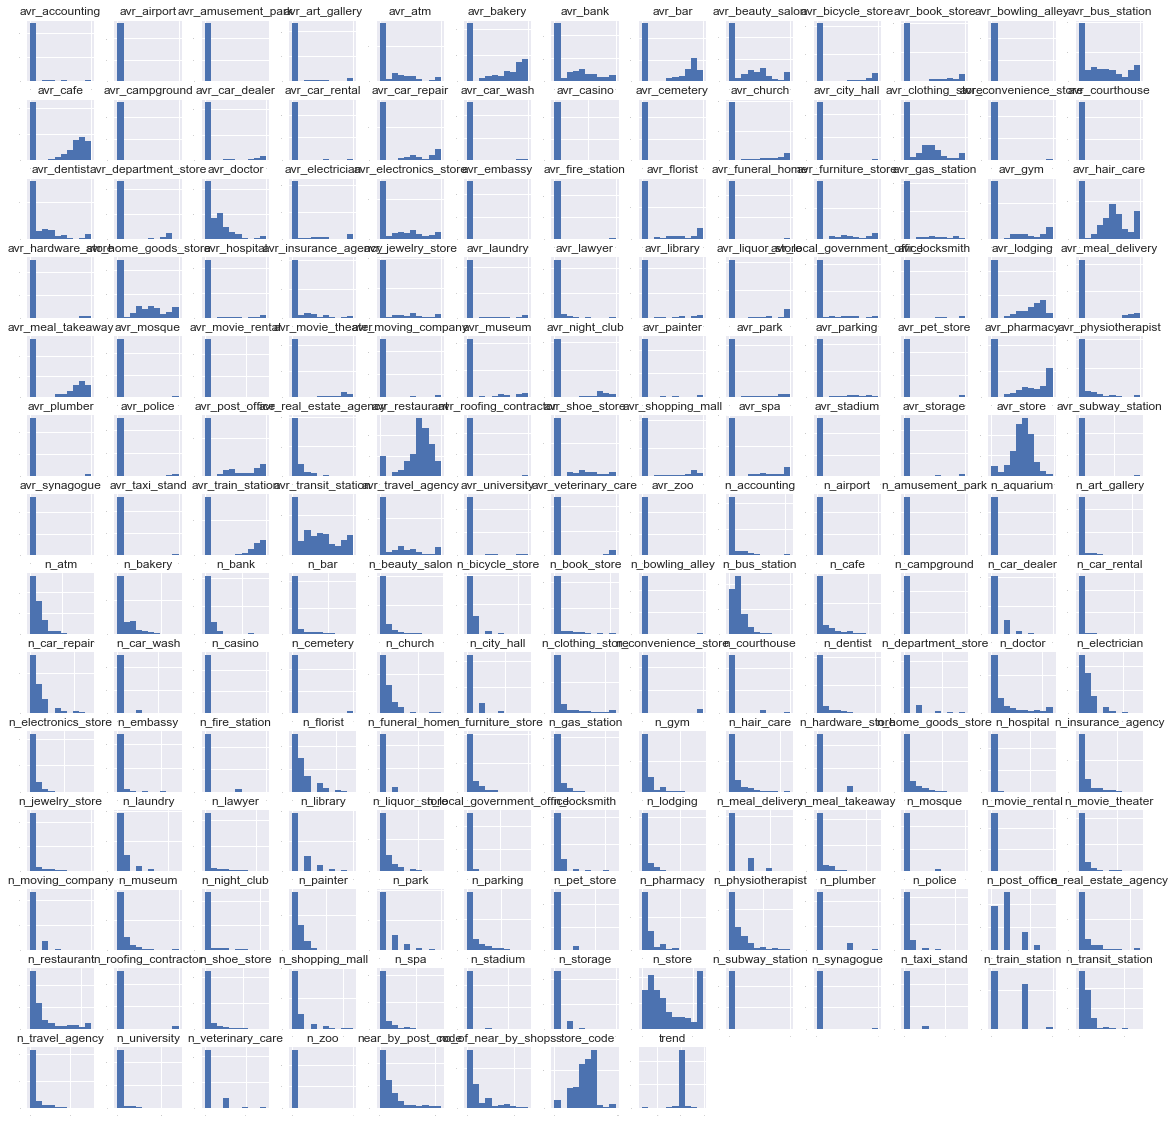

In [5]:
#Visualization of individual attributes
#Histogram
sales_surrounding_pdf.hist(sharex=False,sharey=False,xlabelsize=0.25,ylabelsize=0.25,figsize=(20,20))
pyplot.show()

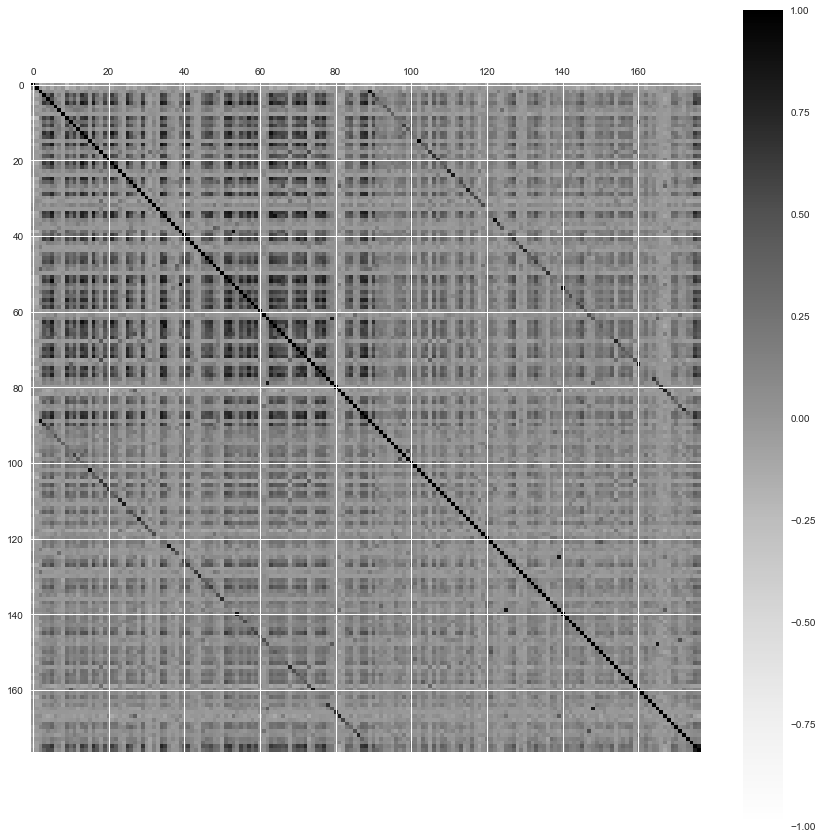

In [6]:
fig = pyplot.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(sales_surrounding_pdf.corr(),vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [44]:
#Create Train,Test without imputation
#X = sales_surrounding_pdf.loc[:, sales_surrounding_pdf.columns != 'total_sales']
#X = sales_surrounding_pdf.loc[:, sales_surrounding_pdf.columns != 'store_code']
y = sales_surrounding_pdf['trend']
X = sales_surrounding_pdf.drop(['trend','store_code'],axis=1)
#X = sales_surrounding_pdf.drop('store_code',axis=1)

#Divide into train and test
validation_size = 0.30
seed = 33
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=validation_size,random_state=seed)

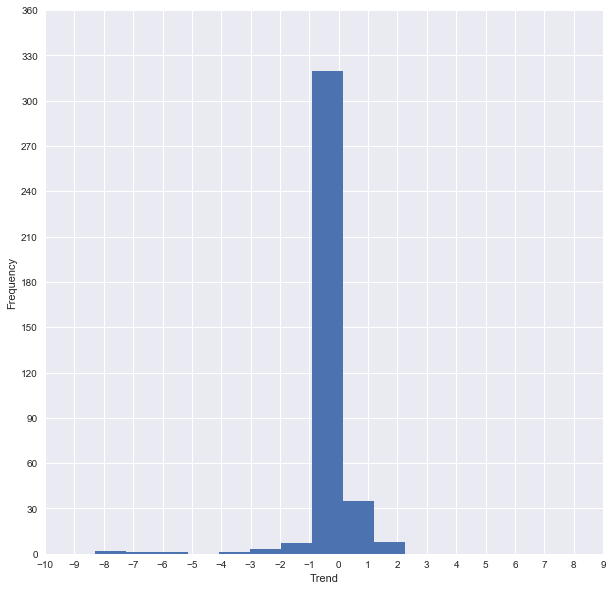

In [45]:
xtick_list = range(-10,10,1)
ytick_list = range(0,y_train.shape[0],30)
y_train.plot(kind='hist',subplots=True,fontsize=10,figsize=(10,10),xticks=xtick_list,yticks=ytick_list)
pyplot.xlabel("Trend")
pyplot.show()

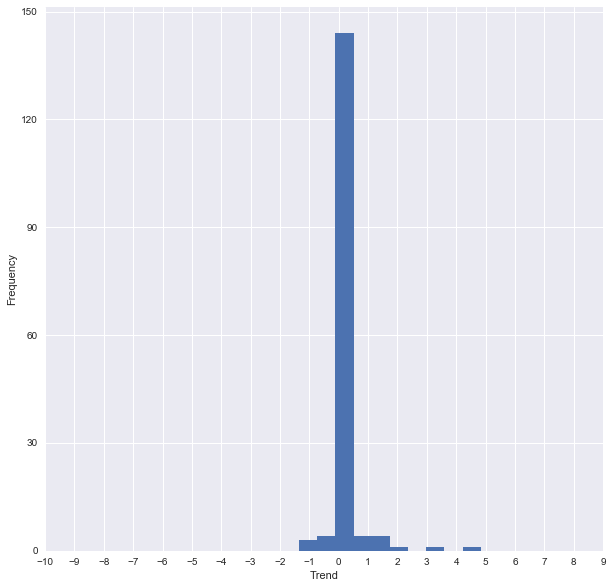

In [46]:
xtick_list = range(-10,10,1)
ytick_list = range(0,y_test.shape[0],30)
y_test.plot(kind='hist',subplots=True,fontsize=10,figsize=(10,10),xticks=xtick_list,yticks=ytick_list)
pyplot.xlabel("Trend")
pyplot.show()

In [47]:
##Find the most balanced point of the data set :
for i in np.arange(-2.0, 5.0, 0.1):
    y_train_sp = y_train.apply(lambda x : 1 if x >=i else 0 )
    y_test_sp = y_test.apply(lambda x : 1 if x >=i else 0)
    print ("Split Point ", i)
    print ("% of 0-class in Test ",y_test_sp.value_counts()[0]/ (y_test_sp.value_counts()[1]+y_test_sp.value_counts()[0])*100)
    print ("% of 0-class in Train ",y_train_sp.value_counts()[0]/ (y_train_sp.value_counts()[1]+y_train_sp.value_counts()[0])*100)
    print("\n")

Split Point  -2.0


KeyError: 0

In [48]:
#Based on the above histogram comparison threshold 50,000 is a good enough to make binary classification target
y_train = y_train.apply(lambda x : 1 if x >=0.5 else 0 )
y_test = y_test.apply(lambda x : 1 if x >=0.5 else 0)

y_test.value_counts()
#Binary Targets created.

0    151
1     11
Name: trend, dtype: int64

In [49]:
y_train.value_counts()

0    360
1     18
Name: trend, dtype: int64

In [50]:
#Find Feature Importance via various methods
#1)Logistic Regression
#1.1) Logistic Regression with L1 Penalty (Lasso)
#2)Decision Tree

# Spot-Check Algorithms
models = []
num_folds = 7
seed = 42
scoring = 'roc_auc'

models.append(('LR', LogisticRegression()))
models.append(('LR with L1 penalty', LogisticRegression(penalty='l1')))
models.append(('CART', DecisionTreeClassifier(max_depth=1)))
# import warnings
# warnings.filterwarnings('ignore')
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(msg)

LR: 0.490917 (0.099917)
LR with L1 penalty: 0.478550 (0.074498)
CART: 0.493048 (0.013337)


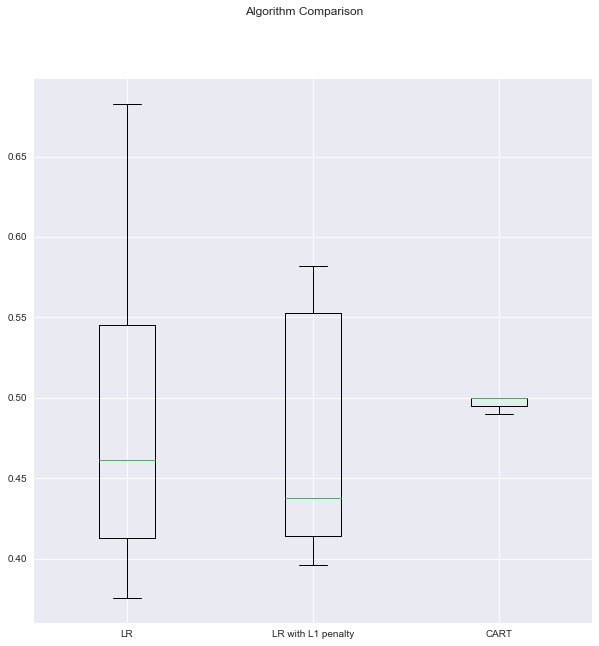

In [51]:
# Compare Algorithms
fig = pyplot.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [52]:
pipelines = []
pipelines.append(('Scaled LR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('Scaled LR with L1', Pipeline([('Scaler', StandardScaler()),('LR with L1',LogisticRegression(penalty='l1'))])))
pipelines.append(('Scaled CART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeClassifier(max_depth=1))])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Scaled LR: 0.503708 (0.101546)
Scaled LR with L1: 0.474093 (0.112337)
Scaled CART: 0.493048 (0.013337)


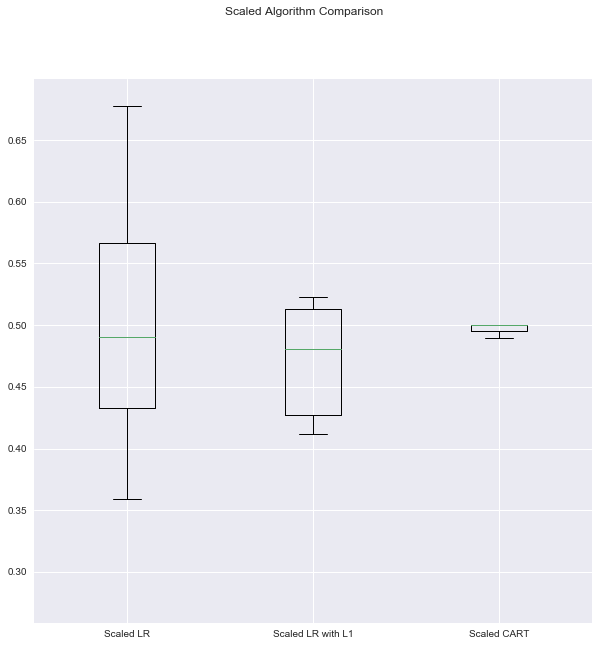

In [53]:
fig = pyplot.figure(figsize=(10,10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [54]:
# ensembles
ensembles = []
ensembles.append(('RF', RandomForestClassifier(n_estimators=500, max_depth=3)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=500, max_depth=3)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.557371 (0.168465)
ET: 0.444640 (0.115661)


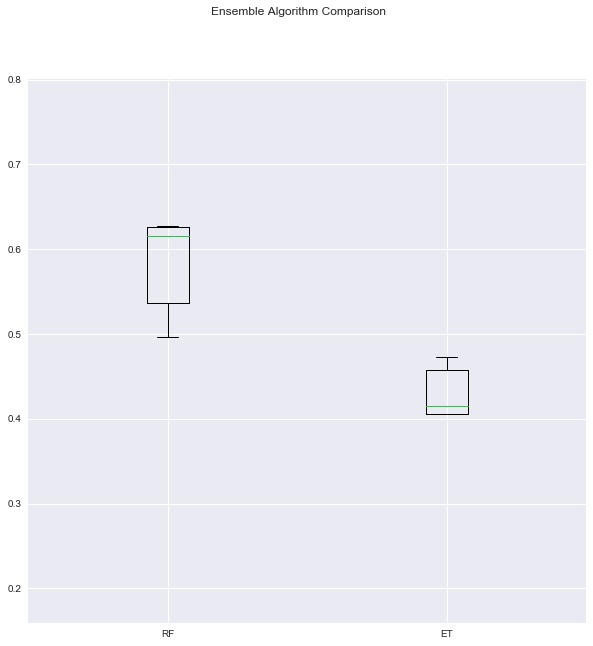

In [55]:
# Compare Algorithms
fig = pyplot.figure(figsize=(10,10))
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [57]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = DecisionTreeClassifier(max_depth=3)
model.fit(rescaledX, y_train)

# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)

print(roc_auc_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.496688741722
[[150   1]
 [ 11   0]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       151
          1       0.00      0.00      0.00        11

avg / total       0.87      0.93      0.90       162



Confusion matrix, without normalization
[[150   1]
 [ 11   0]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 1.    0.  ]]


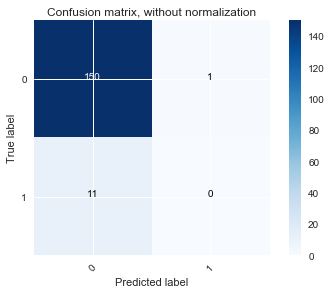

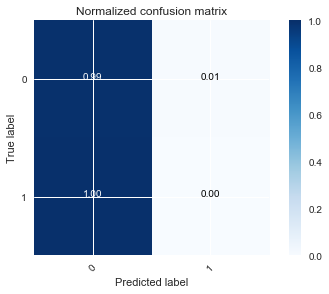

In [58]:
import itertools
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0','1']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

In [59]:
def visualize_tree(tree,feature_names,file_name):
    """Create tree png using graphviz.
    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open(file_name, 'w') as f:
        export_graphviz(tree, out_file=f,feature_names=feature_names)
    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to produce visualization")
visualize_tree(model, X_train.columns,"dt_gini.txt")

In [60]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = DecisionTreeClassifier(max_depth=3,criterion='entropy')
model.fit(rescaledX, y_train)

# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)

print(roc_auc_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
visualize_tree(model, X_train.columns,"dt_entropy.txt")

0.493377483444
[[149   2]
 [ 11   0]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       151
          1       0.00      0.00      0.00        11

avg / total       0.87      0.92      0.89       162



In [61]:
#Find Feature Importance with Random Forest Classifer and Extra Tress Classifier

In [62]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = RandomForestClassifier(n_estimators=10, max_depth=3)
model.fit(rescaledX, y_train)

# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)

print(roc_auc_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.5
[[151   0]
 [ 11   0]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       151
          1       0.00      0.00      0.00        11

avg / total       0.87      0.93      0.90       162



/Users/anilkumarpanda/SoftwareInstalls/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Feature ranking:
1. feature n_store (0.135298)
2. feature n_travel_agency (0.124495)
3. feature n_movie_theater (0.076541)
4. feature n_pharmacy (0.074459)
5. feature avr_restaurant (0.053182)
6. feature avr_train_station (0.046913)
7. feature near_by_post_code (0.039928)
8. feature n_park (0.038818)
9. feature n_campground (0.037946)
10. feature avr_meal_takeaway (0.031458)


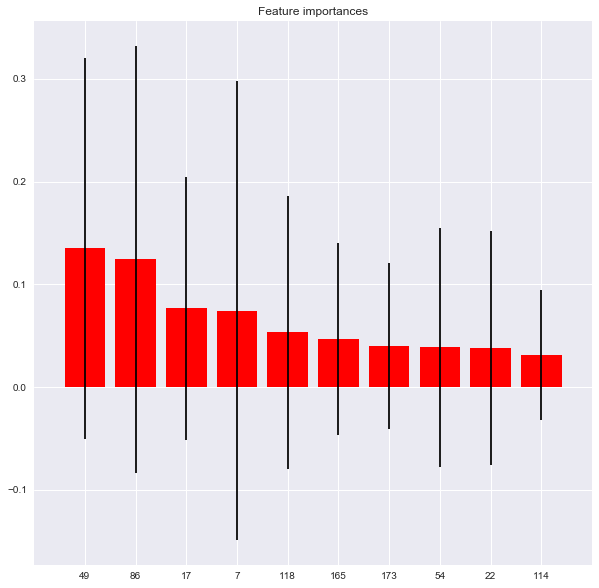

In [63]:
# Build a forest and compute the feature importances
def visualizeFeatureImportance(model,feature_names,no_of_features):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    features = no_of_features
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(features):
        print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))
    # Plot the feature importances of the forest
    plt.figure(figsize=(10,10))
    plt.title("Feature importances")
    plt.bar(range(features), importances[indices[:features]],color="r", yerr=std[indices[:features]], align="center")
    plt.xticks(range(features), indices[:features])
    plt.xlim([-1,features])
    plt.show()

visualizeFeatureImportance(model,X_train.columns,10)

0.5
[[151   0]
 [ 11   0]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       151
          1       0.00      0.00      0.00        11

avg / total       0.87      0.93      0.90       162

Feature ranking:
1. feature avr_laundry (0.087779)
2. feature n_physiotherapist (0.083586)
3. feature near_by_post_code (0.080139)
4. feature n_dentist (0.078218)
5. feature avr_bicycle_store (0.064251)
6. feature n_campground (0.058621)
7. feature n_bakery (0.052776)
8. feature n_parking (0.048892)
9. feature n_movie_theater (0.046424)
10. feature n_convenience_store (0.045583)


/Users/anilkumarpanda/SoftwareInstalls/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


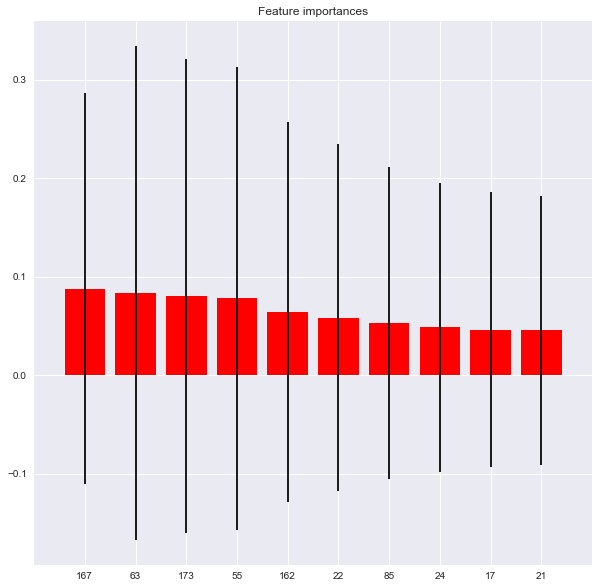

In [64]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_et = ExtraTreesClassifier(n_estimators=10, max_depth=2)
model_et.fit(rescaledX, y_train)

# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)

print(roc_auc_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
visualizeFeatureImportance(model_et,X_train.columns,10)